# Task
Na obrázku vidíte mapu budapeštianskeho metra. Spočítajte zastávky po jednotlivých linkách (označené rôznymi farbami)

In [1]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform, color
from skimage.color import rgb2gray
from typing import Tuple, Optional, List, Dict
from scipy import ndimage, signal
from scipy.spatial import distance

In [111]:
path = "/content/photo_2025-02-02_20-14-07.jpg"
img = io.imread(path)

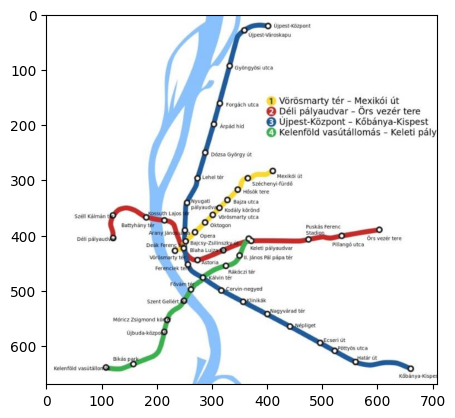

In [3]:
plt.imshow(img)
plt.show()

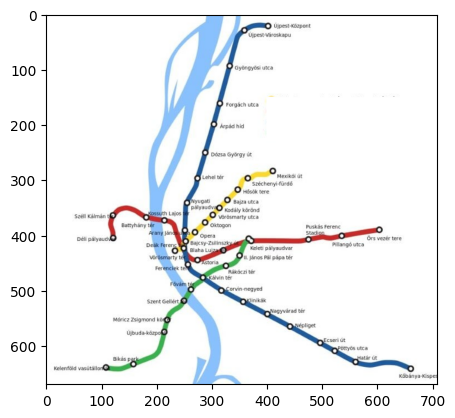

In [113]:
# Removing the inscription by means of a white rectangle
x1, y1, x2, y2 = 399, 150, 710, 230
cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), thickness=-1)
plt.imshow(img)
plt.show()

In [126]:
def DmytroVarich(
    img: np.ndarray,
    show_img: bool = False
) -> Dict[str, int]:

  # Convert to Lab space
  imgLab = color.rgb2lab(img)

  def get_line_color(target_line: str) -> np.ndarray:
    """Function for selecting lines of a certain color"""
    if target_line == "red":
      line_color = np.logical_and.reduce((
          imgLab[:, :, 1] > 40,
          imgLab[:, :, 1] < 100,
          imgLab[:, :, 2] > 25,
          imgLab[:, :, 2] < 65
      ))
    elif target_line == "yellow":
      line_color = np.logical_and.reduce((
          imgLab[:, :, 1] > -20,
          imgLab[:, :, 1] < 25,
          imgLab[:, :, 2] > 50,
          imgLab[:, :, 2] < 100
      ))
    elif target_line == "blue":
      line_color = np.logical_and.reduce((
          imgLab[:, :, 0] <= 40,
          imgLab[:, :, 1] > -5,
          imgLab[:, :, 1] < 100,
          imgLab[:, :, 2] < -28,
          imgLab[:, :, 2] > -100
      ))
    elif target_line == "green":
      line_color = np.logical_and.reduce((
          imgLab[:, :, 1] < -20,
          imgLab[:, :, 1] > -100,
          imgLab[:, :, 2] < 80,
          imgLab[:, :, 2] > -15
      ))
    # elif target_line == "black":
    #   line_color = np.logical_and.reduce((
    #       imgLab[:, :, 0] < 25,
    #   ))
    else:
      raise ValueError(f"Unsupported color: {target_line}. Choose from ['red', 'blue', 'yellow', 'green']")
    return line_color

  # lines color dictionary
  lines_colors = {
        "red": get_line_color("red"),
        "yellow": get_line_color("yellow"),
        "blue": get_line_color("blue"),
        "green": get_line_color("green"),
  }

  stations_count = {}
  # For each line findind their stops
  for line_color, color_mask  in lines_colors.items():
    img_gray = (color_mask  * 255).astype(np.uint8)

    # Morphologic closure
    kernel = np.ones((1, 1), np.uint8)
    img_gray = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)

    # Find station contours
    contours, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by size (eliminate noise)
    min_area = 5
    stations = [c for c in contours if cv2.contourArea(c) > min_area]

    # Vizualization
    if show_img:
      img_with_contours = img.copy()
      cv2.drawContours(img_with_contours, stations, -1, (0, 255, 0), -1)
      plt.imshow(img_with_contours)
      plt.title(f'The {line_color} line has {len(stations) + 1} stops')
      plt.show()

    # Counting stops
    # ! The number of stations is the number of segments plus one.
    stations_count[line_color] = len(stations) + 1

  return stations_count

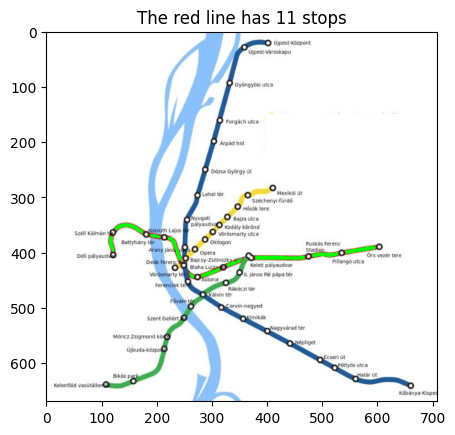

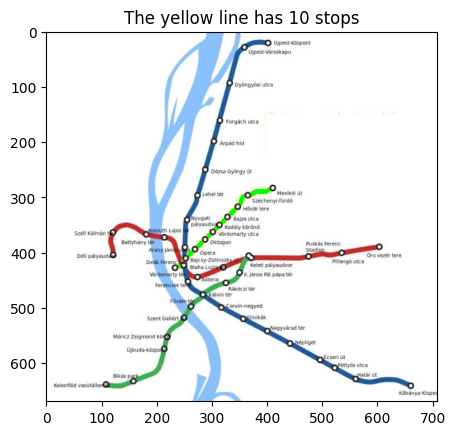

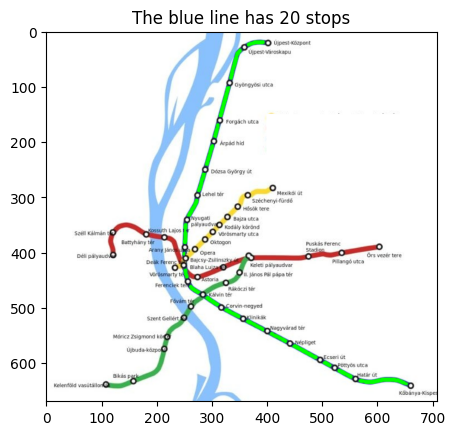

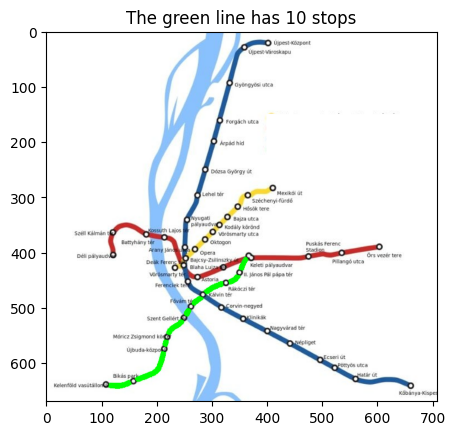

In [128]:
# Using function
stations_count = DmytroVarich(img, True)

In [129]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(stations_count.items()), columns=['Line', 'Stops'])

# Output DataFrame
print(df)

     Line  Stops
0     red     11
1  yellow     10
2    blue     20
3   green     10
